# Transformer로 번역기 만들기

|평가문항|상세기준|
|---|---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.|
|2. Transformer 번역기 모델이 정상적으로 구동된다.|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.|

# 0. 패키지 및 라이브러리 불러오기

In [36]:
import os
import re
import random
import numpy as np

from tqdm.notebook import tqdm   
from tqdm import tqdm_notebook
import sentencepiece as spm
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

# 1. 데이터 다운로드

* [korean-parallel-corpora
: 한국어 말뭉치셋](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
 * korean-english-park.train.tar.gz 사용 예정

# 2. 데이터 정제 및 토큰화

1) 데이터형 중복 방지 및 병렬쌍 만들기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [3]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
cleaned_corpus[0]

('셰이크는 잭슨을 사기꾼 아티스트라고 비난하며 앨범과 자서전 발간을 위해 7백만 달러의 선금을 지불했으나 그는 그 어느 것도 제작하지 않았다고 주장하고 있습니다.',
 "The sheikh is calling Jackson a rip-off artist, claiming he took $7 million as an advance on an album and an autobiography, but hasn't produced either.")

2) 데이터 정제
* 모든 입력을 소문자로 변환
* 알파벳, 문장부호, 한글만 남기고 모두 제거
* 문장부호 양옆에 공백 추가
* 문장 앞뒤의 불필요한 공백 제거

In [4]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[' ']+", " ", sentence)
    sentence = re.sub(r"[^a-zA-Z|0-9|ㄱ-하- | 가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

3) 한글 말뭉치 kor_cors와 영문 말뭉치 eng_corpus를 각각 분리 후 정제하여 토큰화
* SentencePiece 사용
* return은 ko_tokenizer, en_tokenizer
* set_encode_extra_options("bos:eos") 함수를 실행해서 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 한다.


1. 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)

2. 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.

3. 특수 토큰의 인덱스를 아래와 동일하게 지정합니다. < PAD > : 0 / < BOS > : 1 / < EOS > : 2 / < UNK > : 3

In [5]:
kor_corpus = []
eng_corpus = []

for tmp in cleaned_corpus:
    tmp_ko = preprocess_sentence(tmp[0])
    tmp_en = preprocess_sentence(tmp[1], s_token=True, e_token=True)
    kor_corpus.append(tmp_ko)
    eng_corpus.append(tmp_en)

print(len(kor_corpus))
print(len(eng_corpus))
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])

78968
78968
Korean: limited and temporary 제한적이거나 임시적인 republicans , acorn spar over voter registration 공화당 , 미자격 유권자를 등록한 오바마 지지 조직 비난     2008 . 10
English: bush says the step which follows similar moves by u . s . allies is limited and temporary , adding he is confident it will help get markets working again .


In [6]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    model_name= 'spm_GD10_'+lang
    
    # [[YOUR CODE]]
    ##모델 생성 경로
    temp_file = os.getenv('HOME')+'/aiffel/transformer/GD10_'+lang+'.ko'

    # 함수 파라미터 lang의 단어를 적용한 파일 코퍼스 파일 만듬
    with open(temp_file, 'w') as f:
        for row in corpus:   # lang corpus를 활용합니다.
            f.write(str(row) + '\n')
    
    spm.SentencePieceTrainer.Train(
         '\
        --input={} \
        --model_prefix={} \
        --vocab_size={} \
        --pad_id={} \
        --bos_id={} \
        --eos_id={} \
        --unk_id={}'.format(temp_file, model_name, vocab_size, pad_id, bos_id, eos_id, unk_id)    
    )
    #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name+'.model')
    
    return tokenizer

In [7]:
SRC_VOCAB_SIZE = 10000
TGT_VOCAB_SIZE = 10000

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

model과 vocab이 생성 되었는 지 확인할 것

In [8]:
!ls -l

total 23644
lrwxrwxrwx 1 root root       12 Oct 27 05:02 data -> /aiffel/data
-rw-r--r-- 1 root root 10832185 Oct 27 11:07 GD10_en.ko
-rw-r--r-- 1 root root 12140343 Oct 27 11:07 GD10_ko.ko
-rw-r--r-- 1 root root    39174 Oct 27 11:07 GD10_Transfomer_Translator.ipynb
-rw-r--r-- 1 root root   407374 Oct 27 11:07 spm_GD10_en.model
-rw-r--r-- 1 root root   178670 Oct 27 11:07 spm_GD10_en.vocab
-rw-r--r-- 1 root root   416952 Oct 27 11:07 spm_GD10_ko.model
-rw-r--r-- 1 root root   188273 Oct 27 11:07 spm_GD10_ko.vocab


4) 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환

In [9]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)


# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm_notebook(range(len(kor_corpus))):
    token_ko = ko_tokenizer.encode_as_ids(kor_corpus[idx]) # 서브워드 시퀀스 변환
    token_en = en_tokenizer.encode_as_ids(eng_corpus[idx]) # 정수 시퀀스 변환
       
        
    if len(token_ko) <= 50  and len(token_en) <= 50:
        src_corpus.append(token_ko)
        tgt_corpus.append(token_en)

# 토큰 길이 정제 확인       
print(len(src_corpus))
print(len(tgt_corpus))
print("Korean:", src_corpus[10])
print("-"*80)
print("English:", tgt_corpus[10])
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/78968 [00:00<?, ?it/s]

65795
65795
Korean: [464, 529, 7, 1145, 1193, 157, 1187, 9, 1845, 24, 5336, 18, 1064, 4, 683, 23, 7455, 9, 147, 1742, 7, 1845, 7699, 755, 10, 658, 233, 27, 5]
--------------------------------------------------------------------------------
English: [1, 166, 15, 54, 4787, 172, 1666, 4, 8, 982, 26, 317, 9, 22, 2046, 14, 2418, 4, 8, 14, 4441, 2089, 1104, 9, 1146, 7098, 271, 6, 7, 2]


In [10]:
print(enc_train.shape)
print(dec_train.shape)

(65795, 50)
(65795, 50)


# 3. 모델 설계

### Positional_encoding

In [11]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### Multi-Head Attention

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network

In [13]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder Layer

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Decoder Layer

In [15]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder Define

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder Define

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transfomer

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking
* 아래 함수가 제대로 동작되지 않아서 TensorFlow 공홈에 있는 Transformer를 참고 하였음.
* 이 함수를 적용 시 학습단계에서 다음과 같은 error 발생
 * invalidargumenterror: in[0] mismatch in[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [op:batchmatmulv2]

```Python
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask
```

### Masking 추가

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [20]:
def generate_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

### Masking 시각화

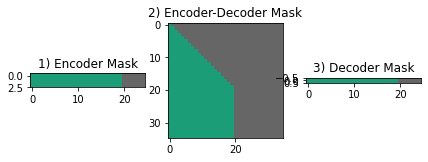

In [22]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### Learning Rate Scheduler
Transformer는 고정된 Learning Rate를 사용하지 않았음.

In [23]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# 4. 훈련하기

1. 2 Layer를 가지는 Transformer를 선언하세요.(하이퍼파라미터는 자유롭게 조절합니다.) 

In [24]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=10000,
    tgt_vocab_size=10000,
    pos_len=50,
    dropout = 0.3
)

2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [25]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09, 
    name='Adam'
)

3. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [26]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 함수를 정의하세요. 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [27]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [28]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [29]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [30]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

5. 학습을 진행합니다.매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [31]:
BATCH_SIZE = 32
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]



for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama has obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are they to be in the city .
Input: 커피는 필요 없다.
Predicted translation: it is not , it is not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed in the deaths of the deaths .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city city city is a city of city city city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not clear .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed by a suicide bomber .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is likely to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: hundreds of people are homeless to be in the city .
Input: 커피는 필요 없다.
Predicted translation: we need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was destroyed .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is like a city .
Input: 커피는 필요 없다.
Predicted translation: don t need to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a huge president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city .
Input: 커피는 필요 없다.
Predicted translation: do not need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen others were killed .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is home .
Input: 커피는 필요 없다.
Predicted translation: don t need cheap .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven dead were , the death toll from seven .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in the city of old city .
Input: 커피는 필요 없다.
Predicted translation: there is need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city s young mountain city .
Input: 커피는 필요 없다.
Predicted translation: don t need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen who were killed , 139 .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is gonna be a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the city s san mateo city .
Input: 커피는 필요 없다.
Predicted translation: don t need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven wounded .


  0%|          | 0/2057 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will president the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s pets .
Input: 커피는 필요 없다.
Predicted translation: don t necessarily .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , and 10 victims were all killed .


## 예문
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Input: 오바마는 대통령이다.
Predicted translation: obama will president the president .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


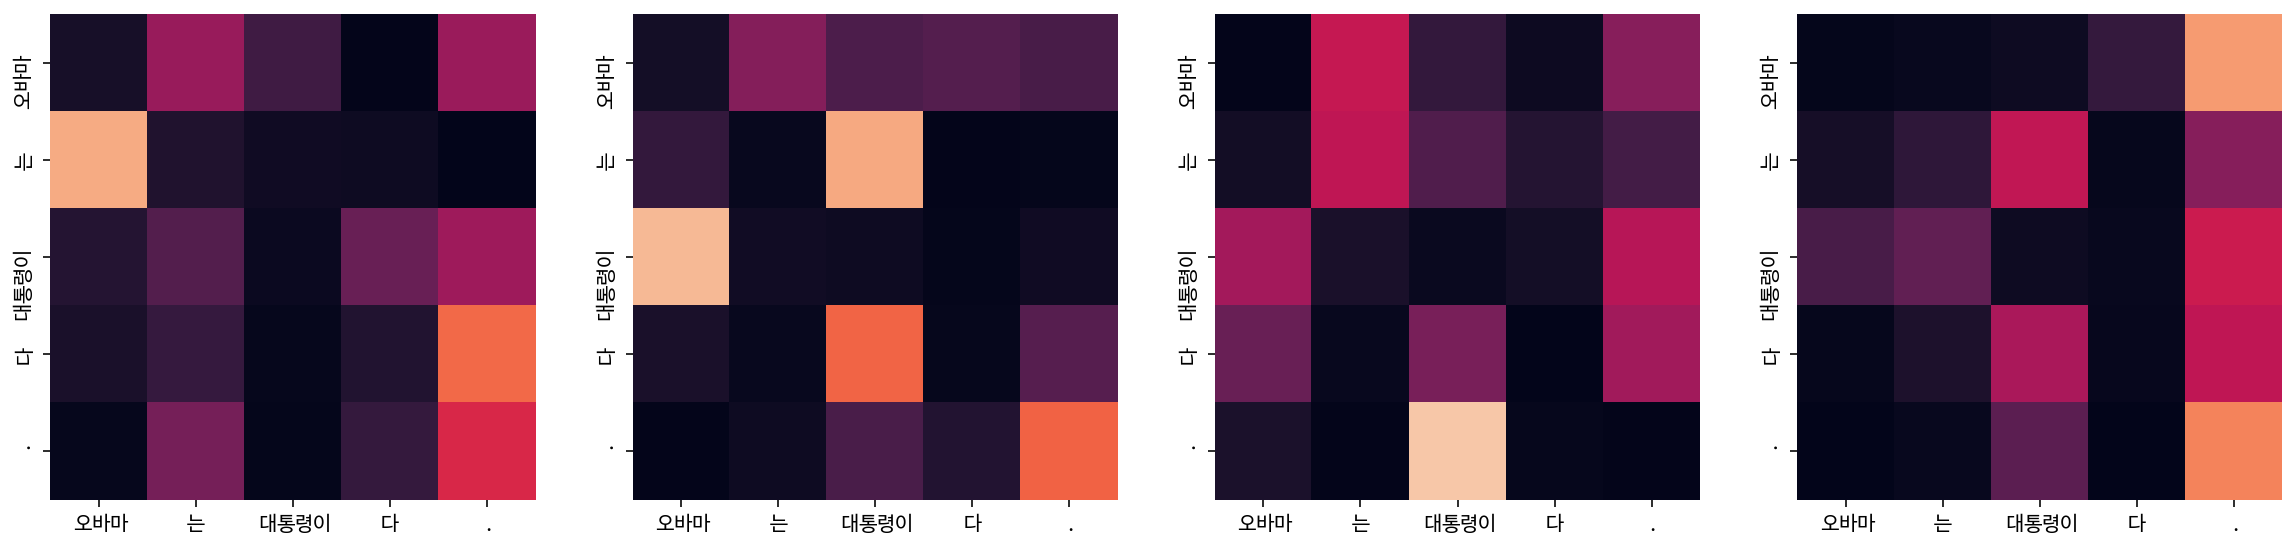

Encoder Layer 2


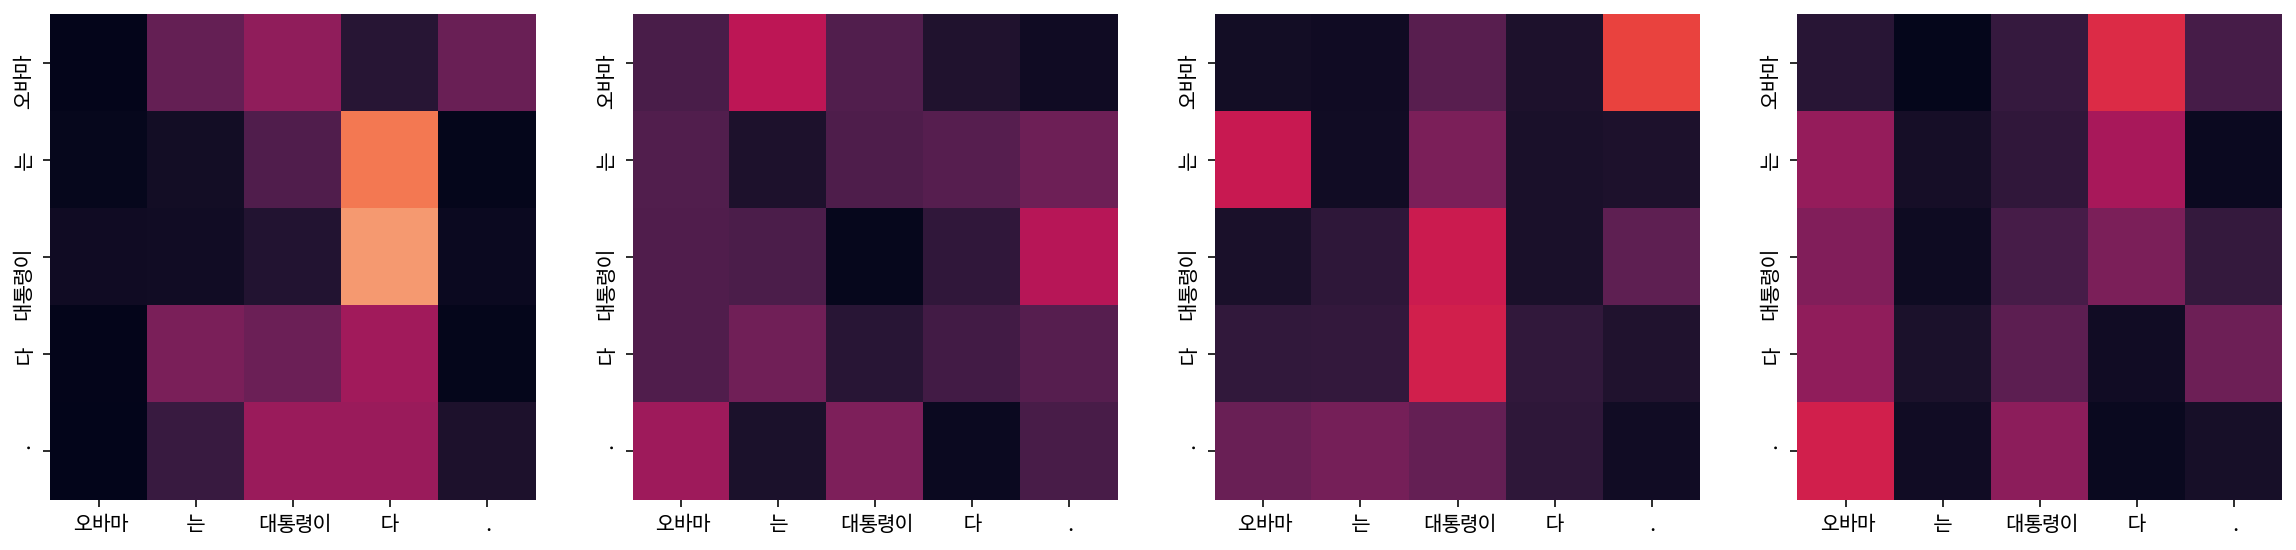

Decoder Self Layer 1


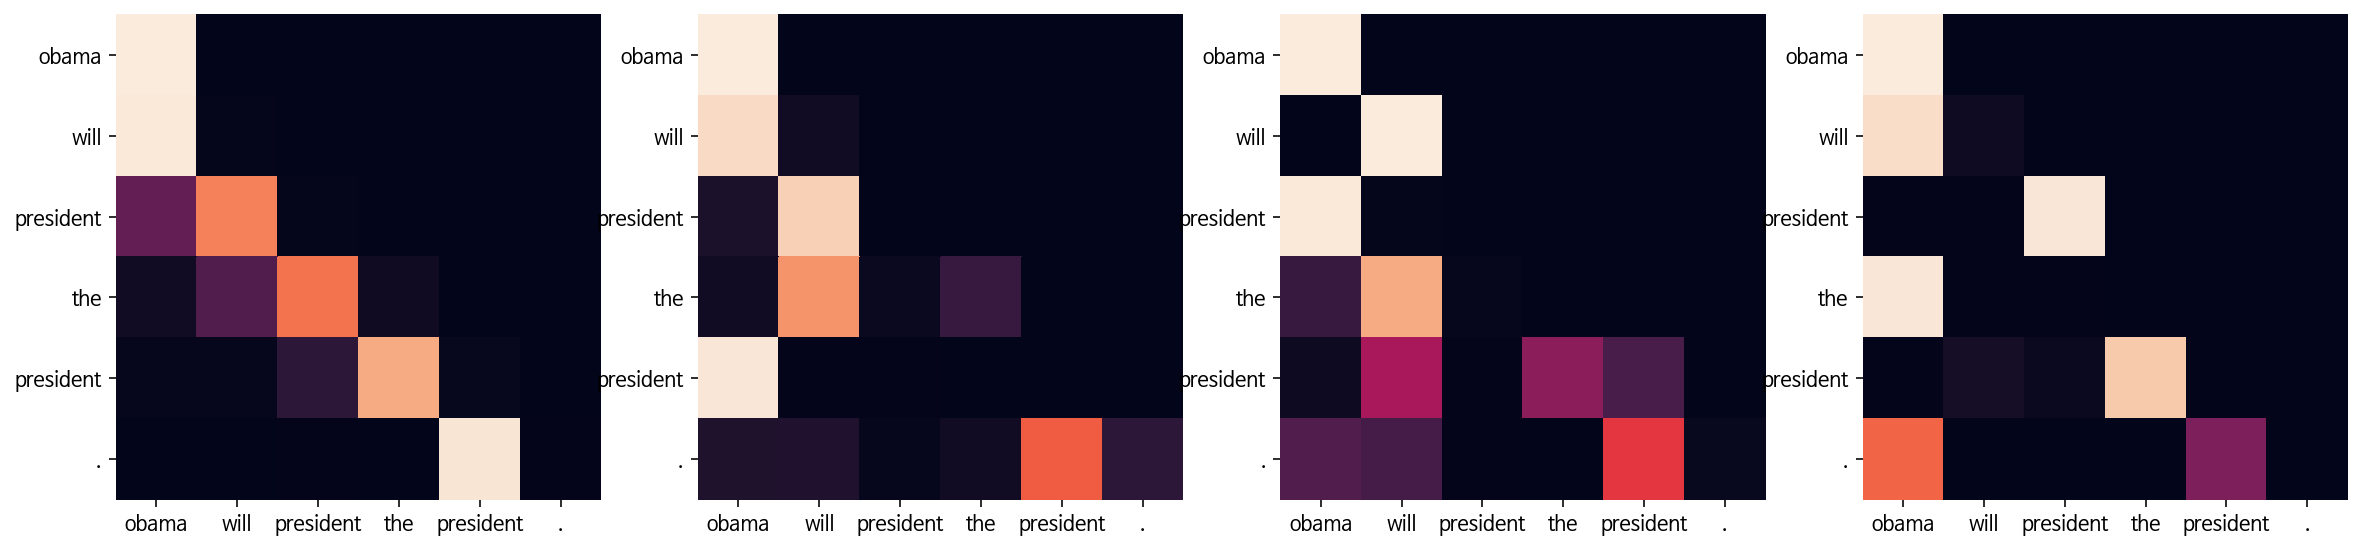

Decoder Src Layer 1


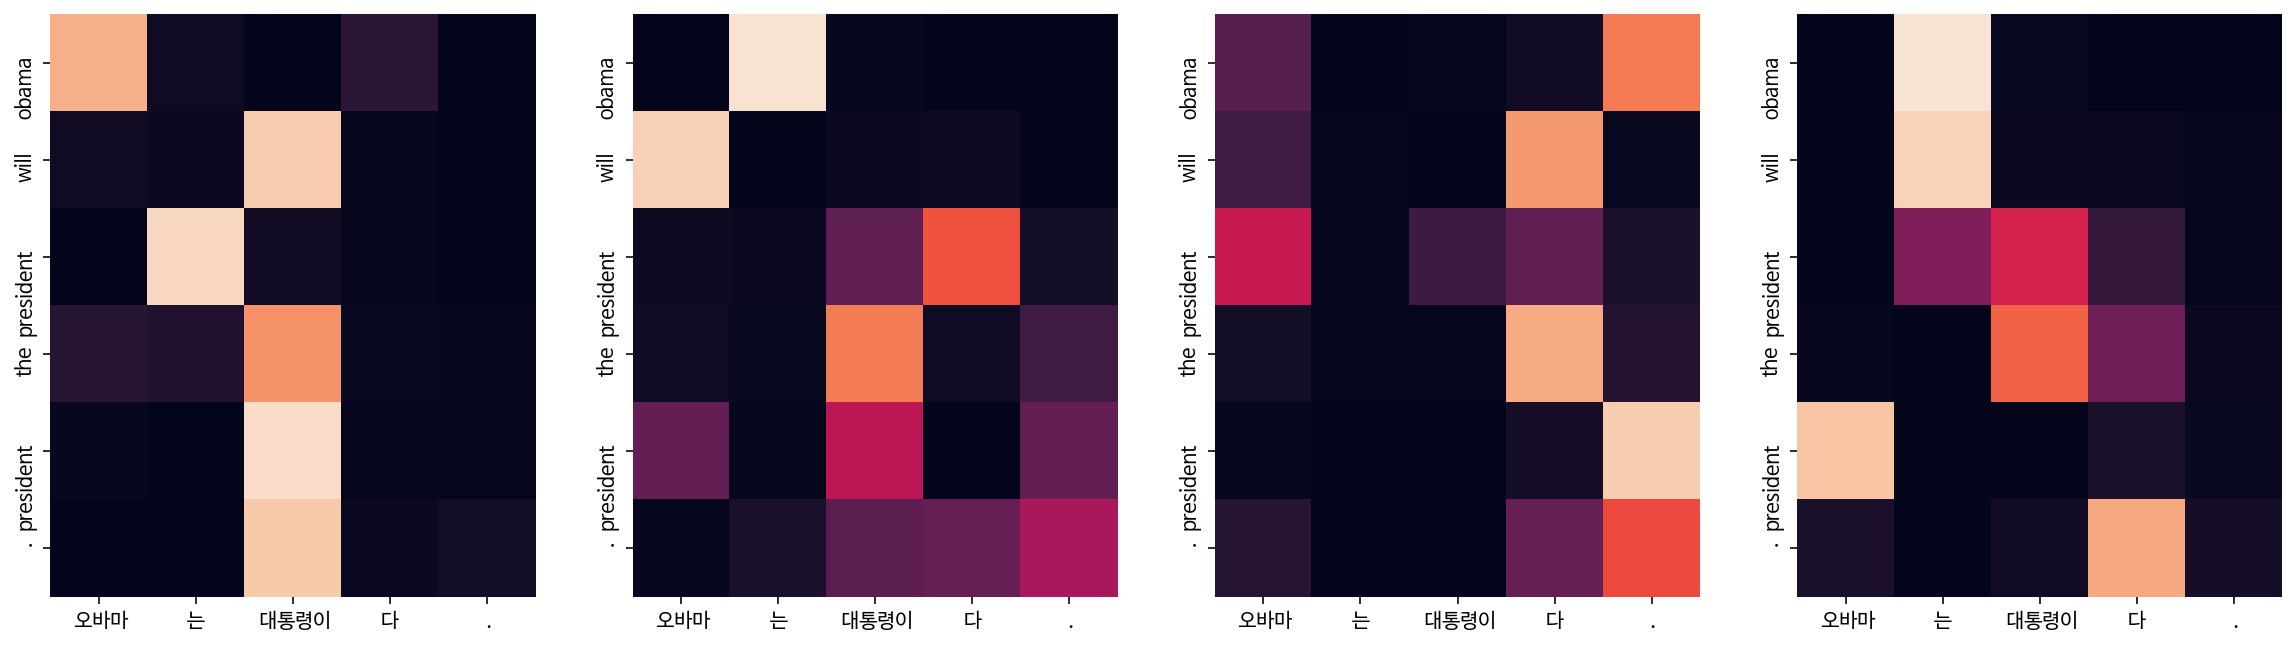

Decoder Self Layer 2


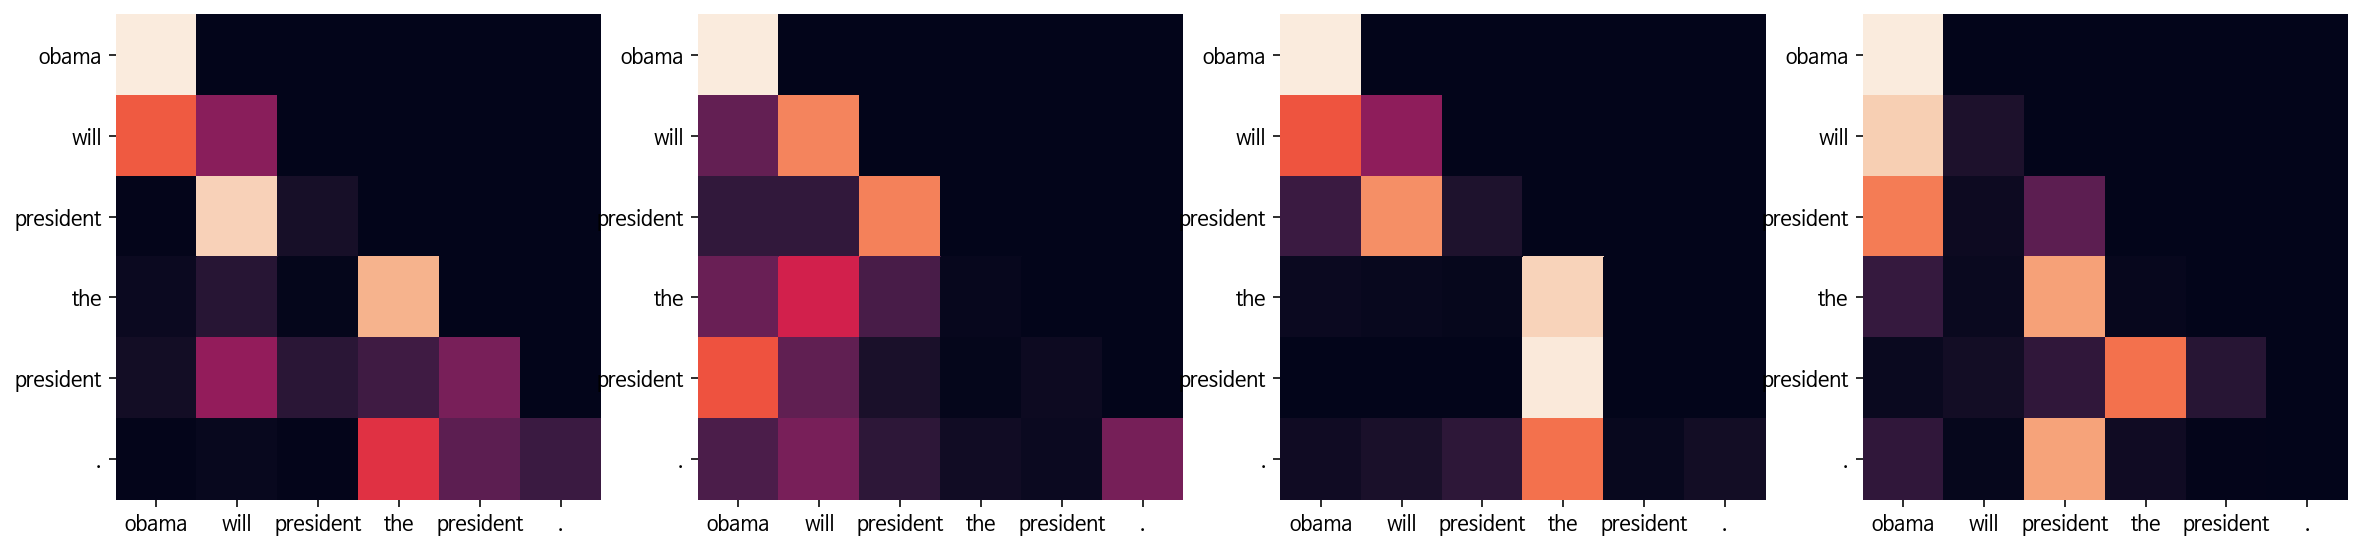

Decoder Src Layer 2


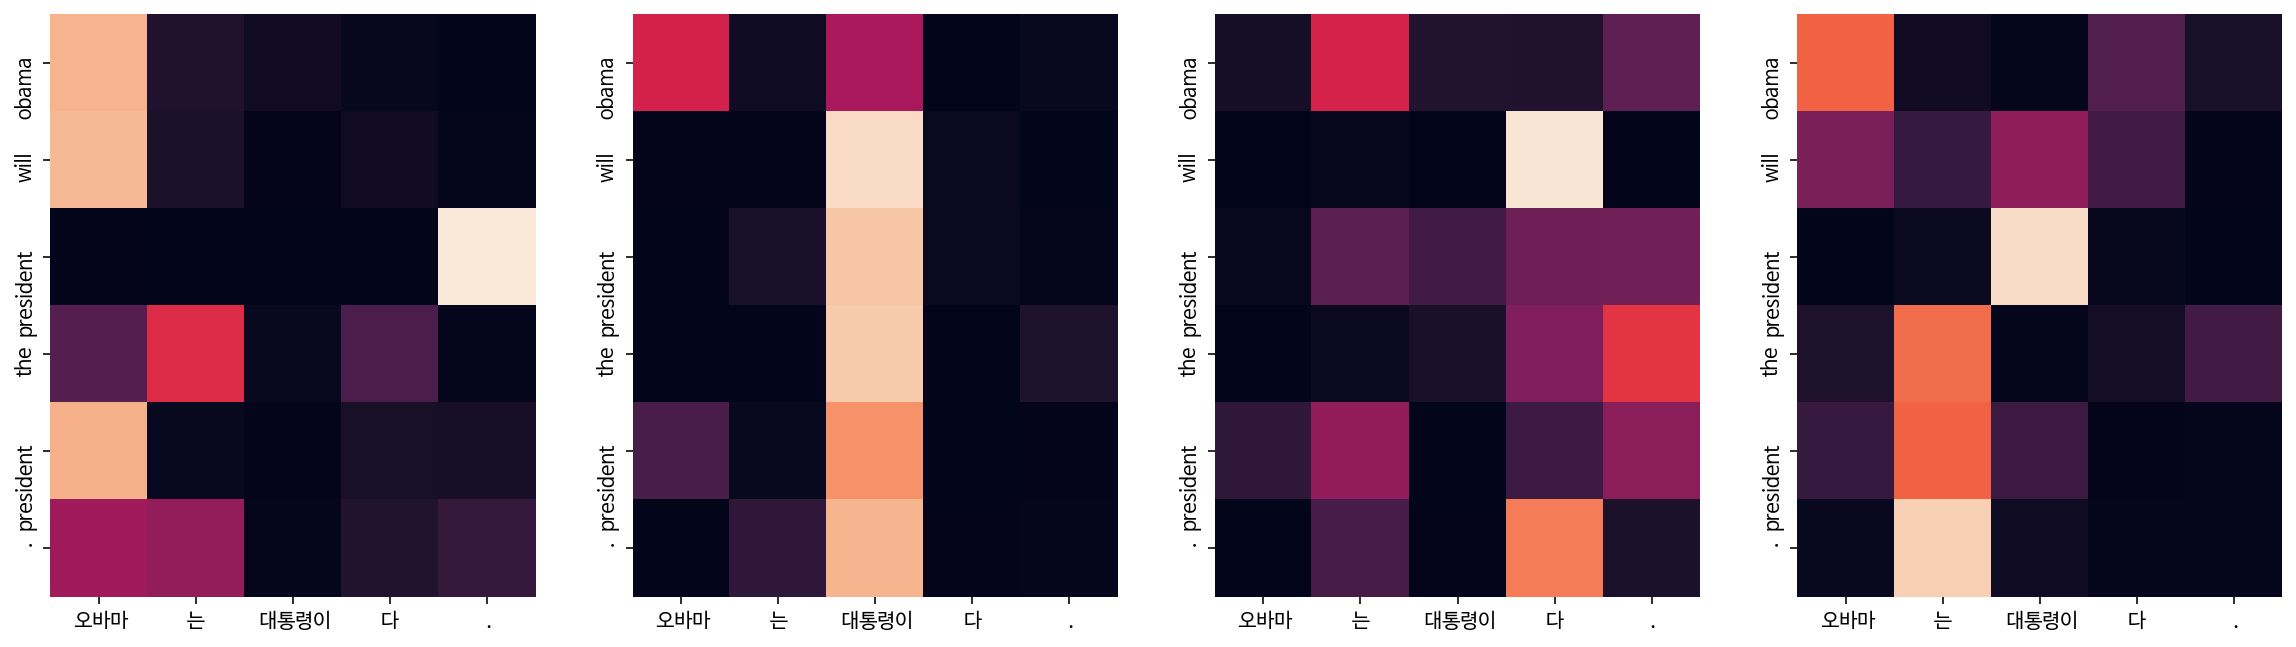

In [37]:
sentence = '오바마는 대통령이다.'
translate(sentence, transformer, ko_tokenizer, en_tokenizer,True)

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s pets .
Encoder Layer 1


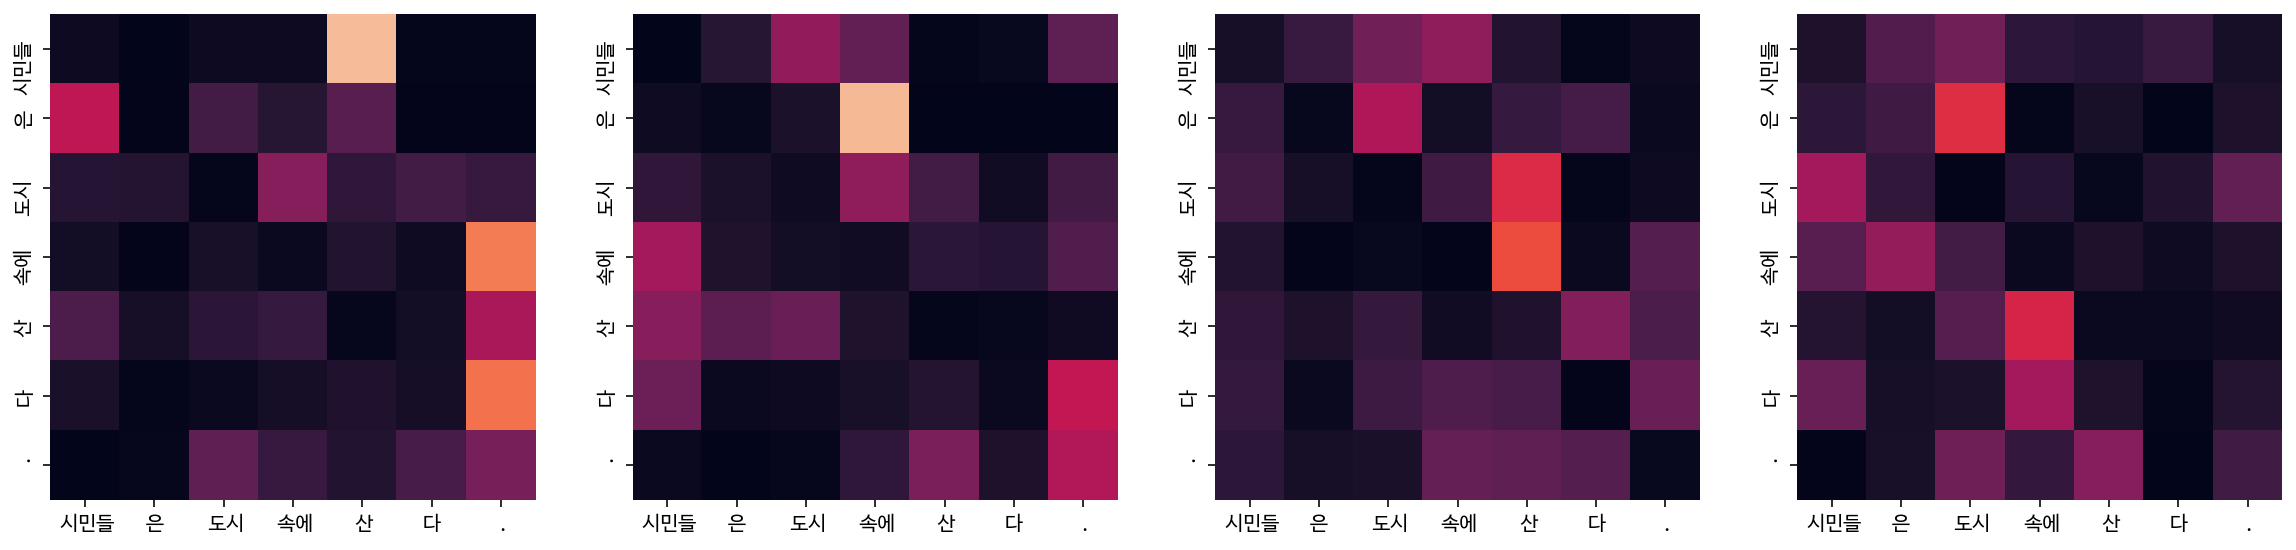

Encoder Layer 2


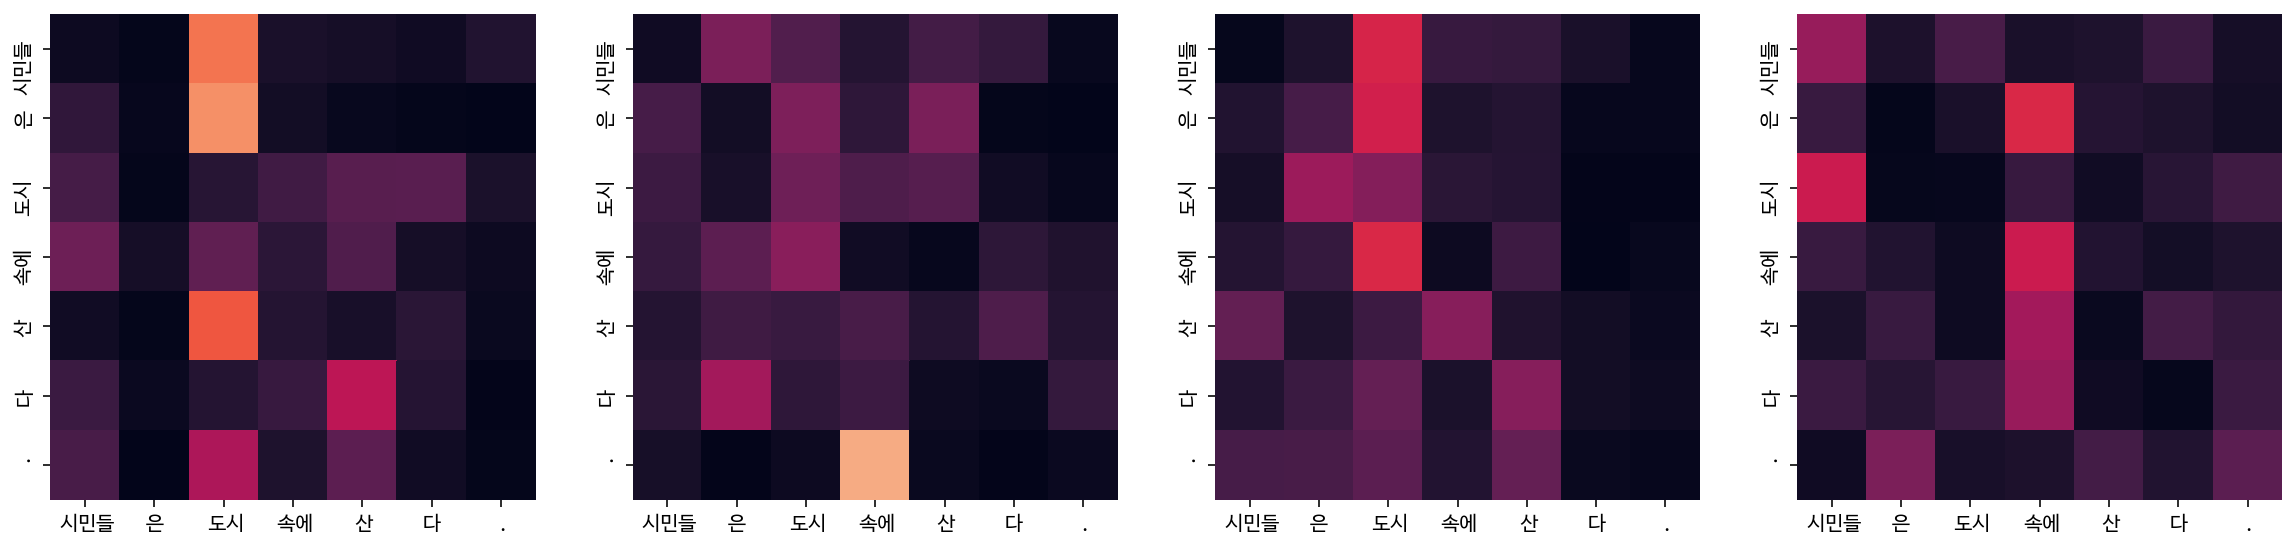

Decoder Self Layer 1


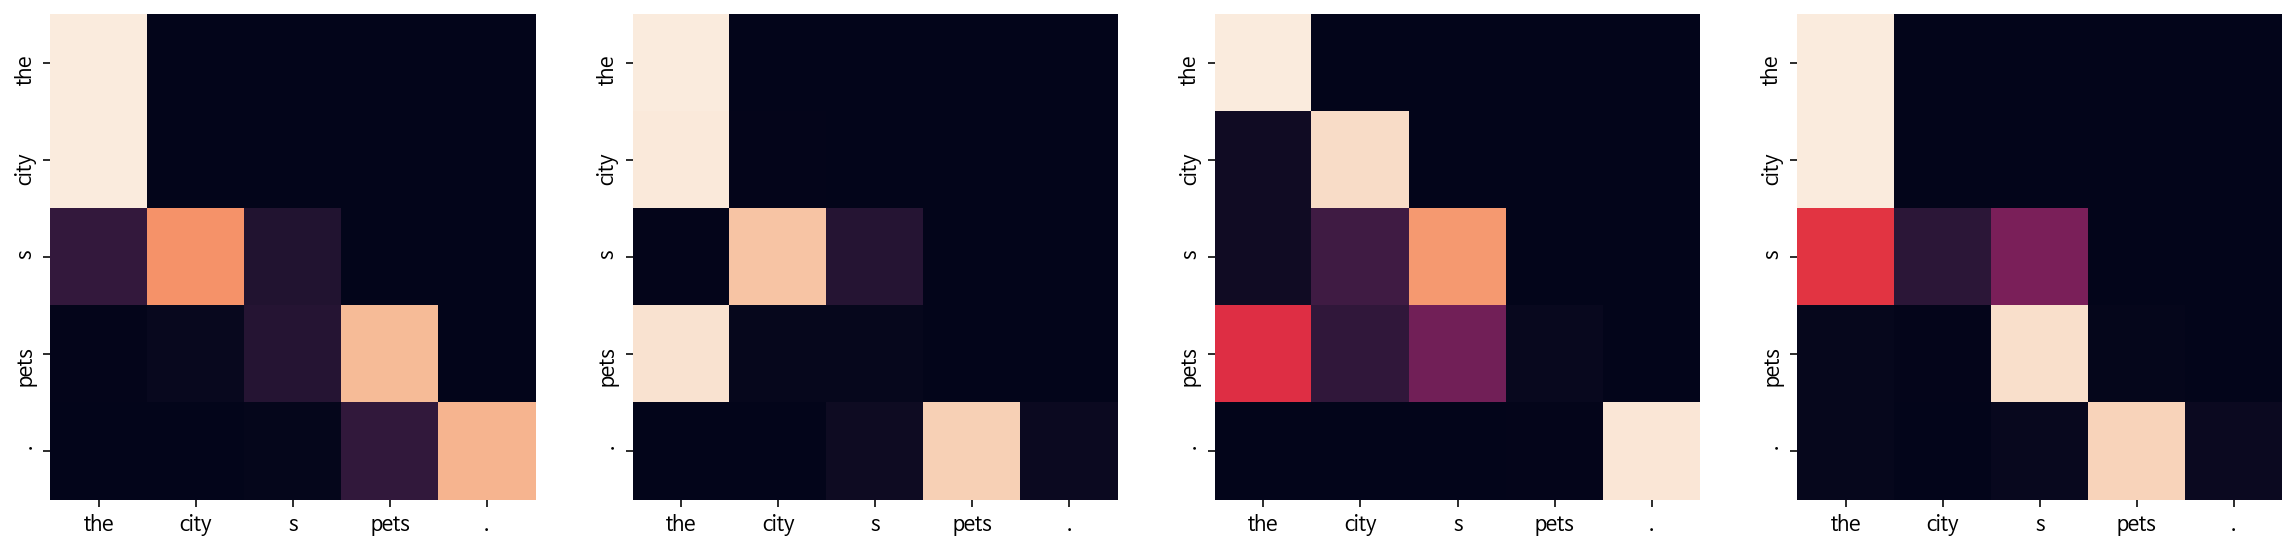

Decoder Src Layer 1


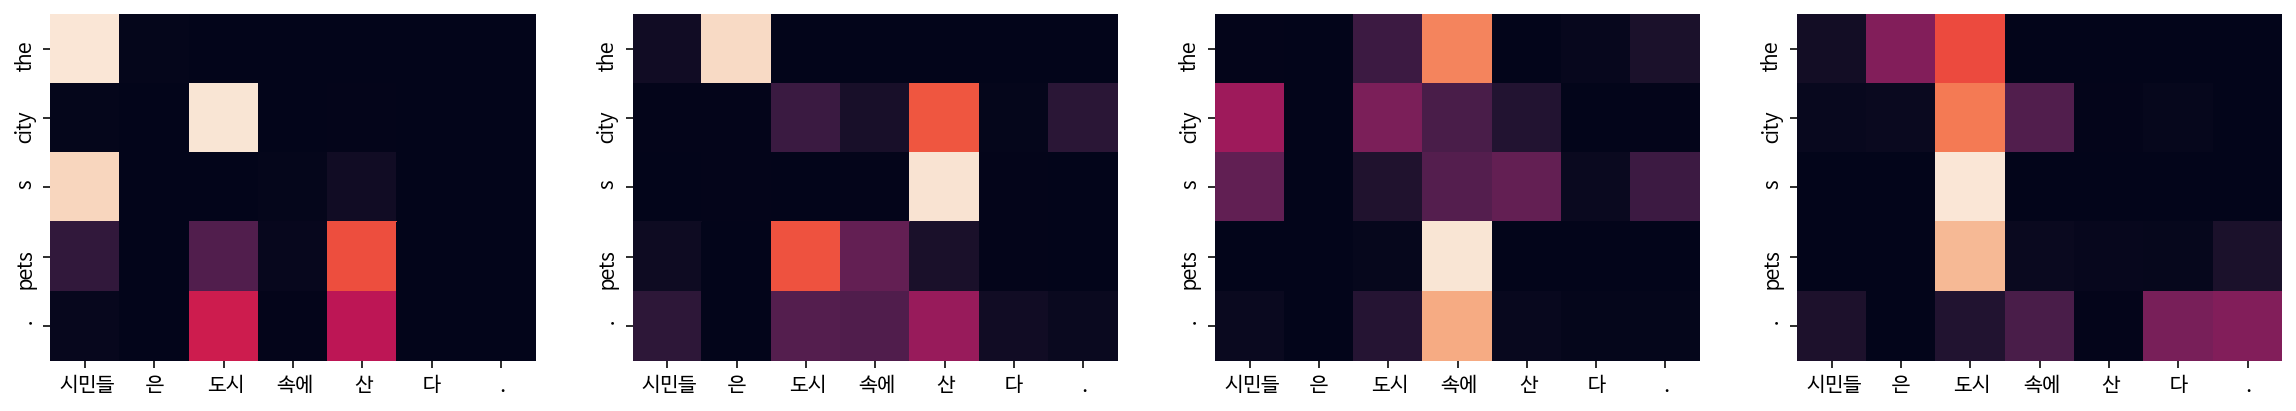

Decoder Self Layer 2


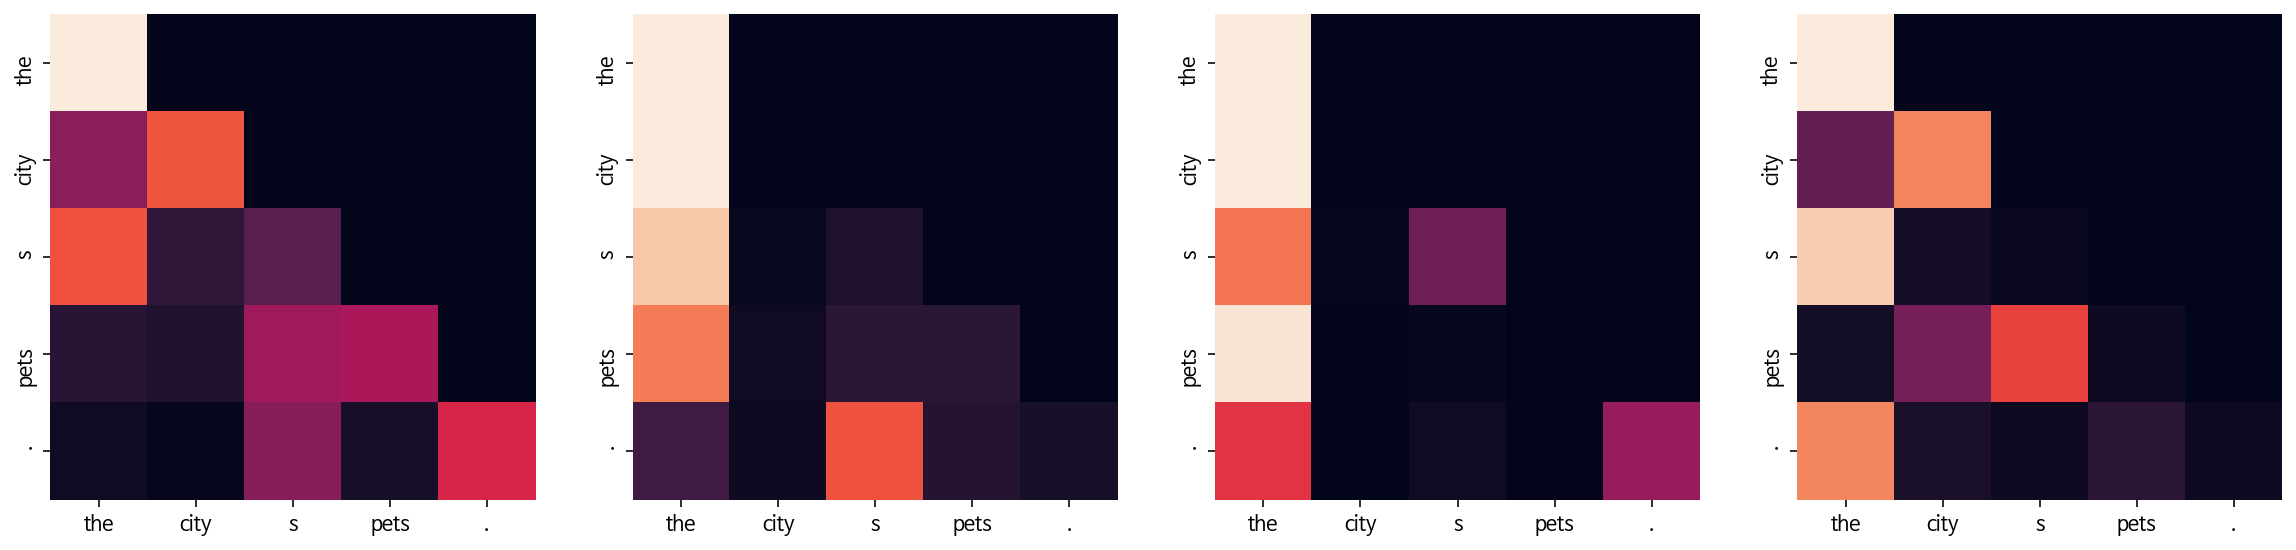

Decoder Src Layer 2


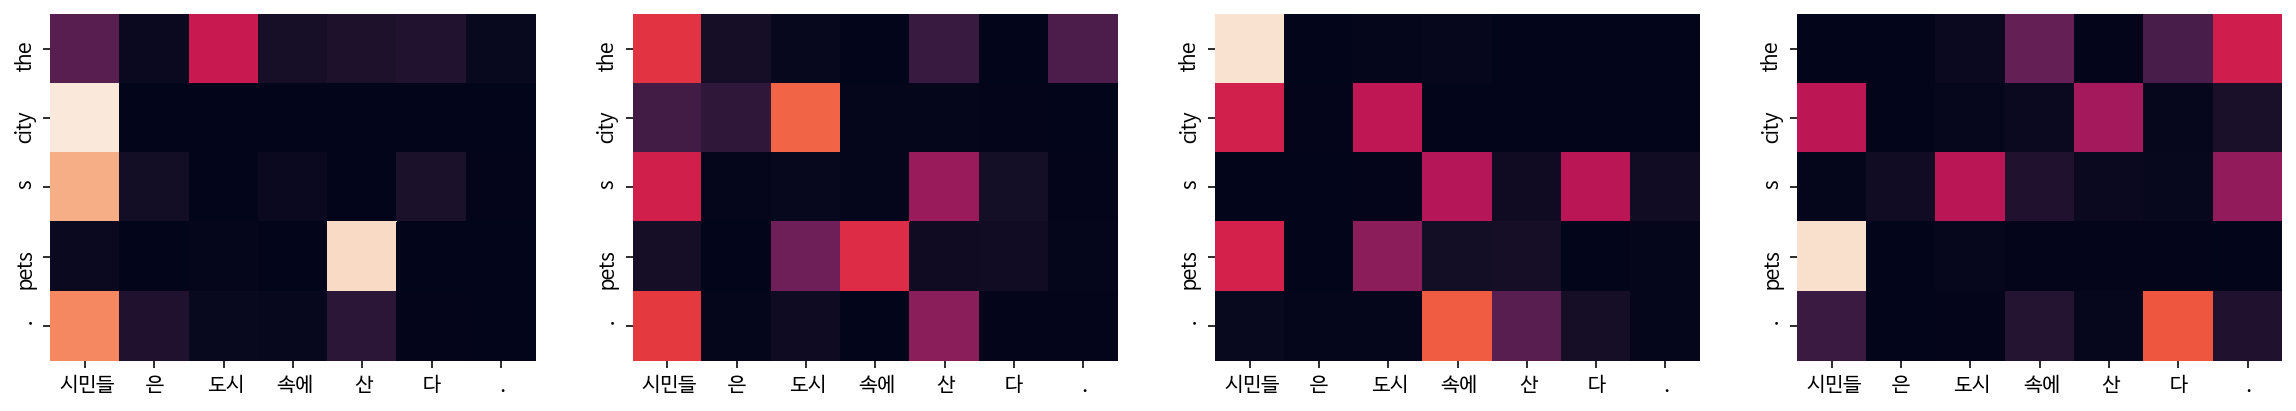

In [38]:
sentence = '시민들은 도시 속에 산다.'
translate(sentence, transformer, ko_tokenizer, en_tokenizer,True)

Input: 커피는 필요 없다.
Predicted translation: don t necessarily .
Encoder Layer 1


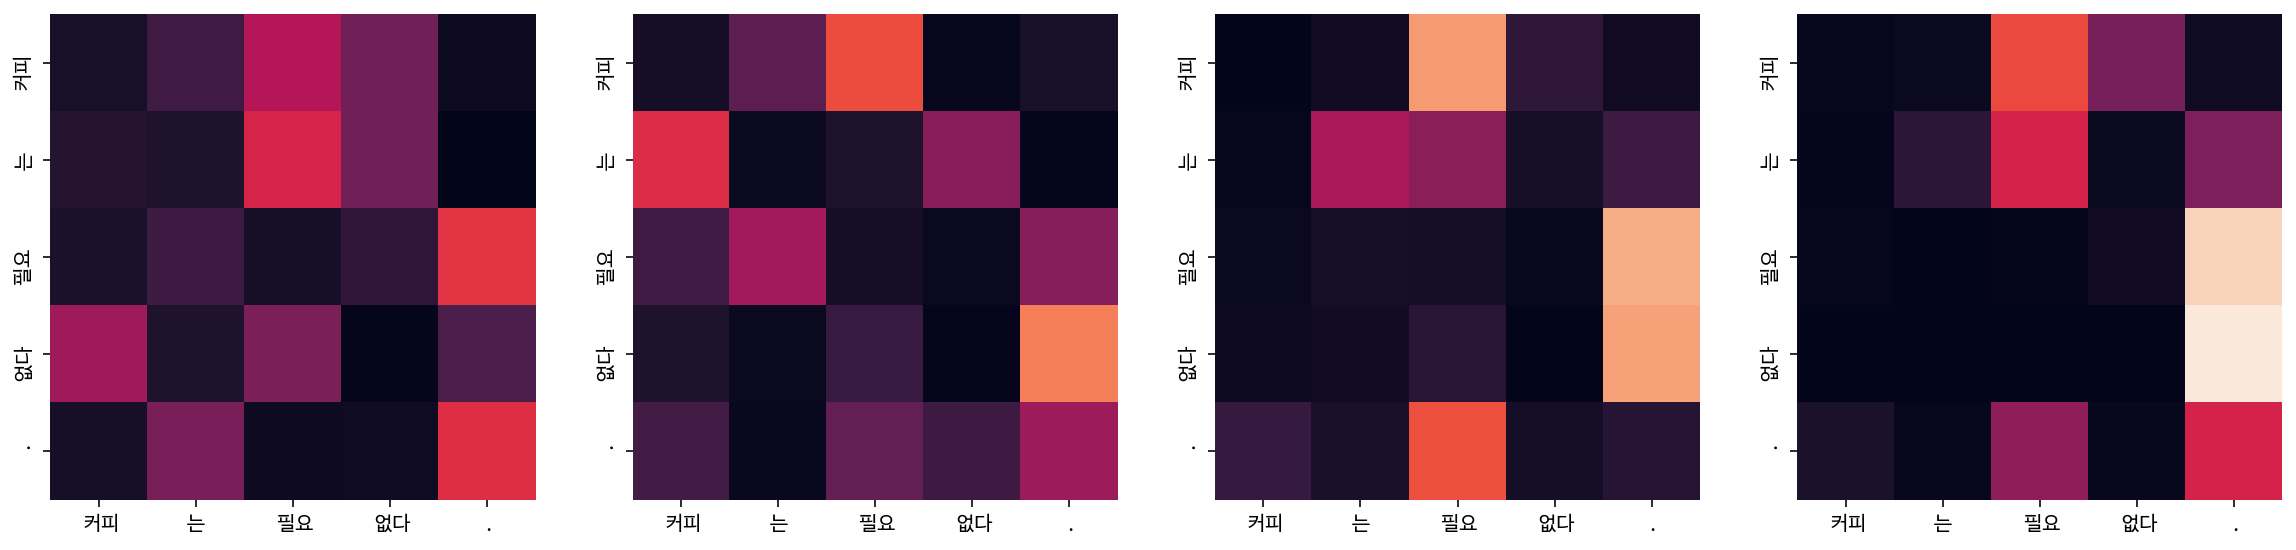

Encoder Layer 2


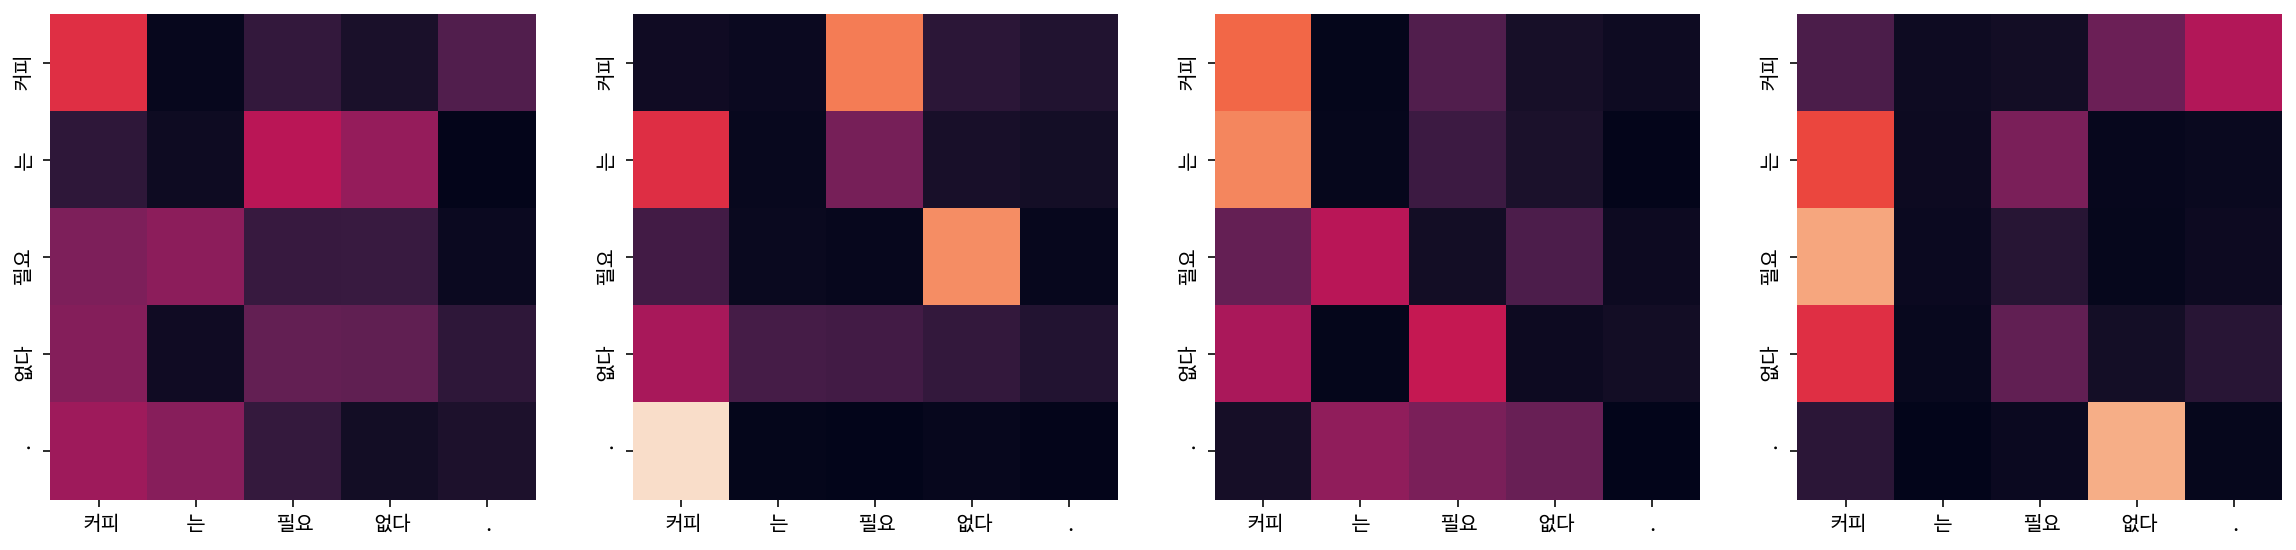

Decoder Self Layer 1


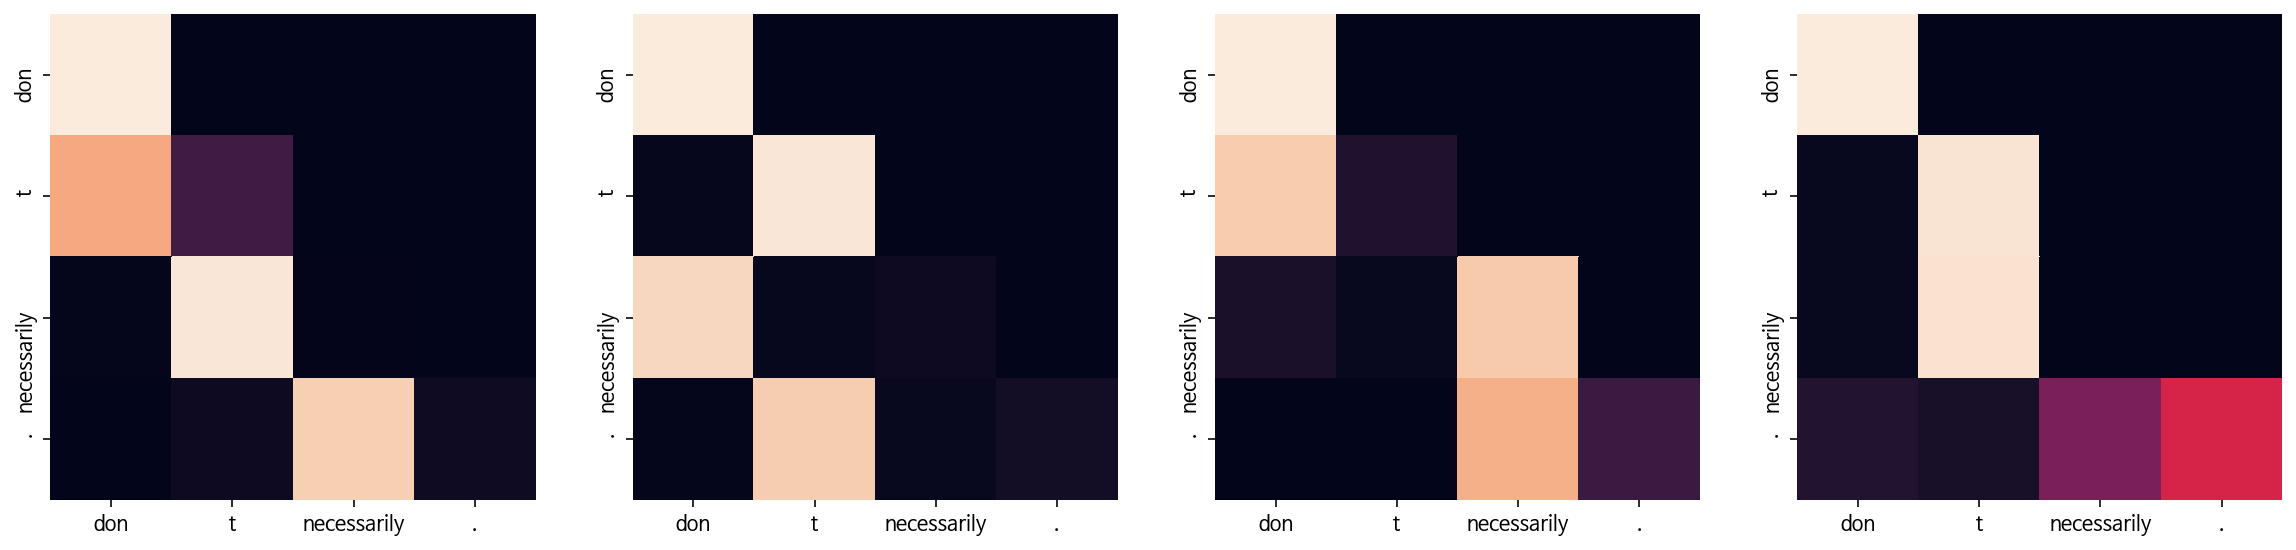

Decoder Src Layer 1


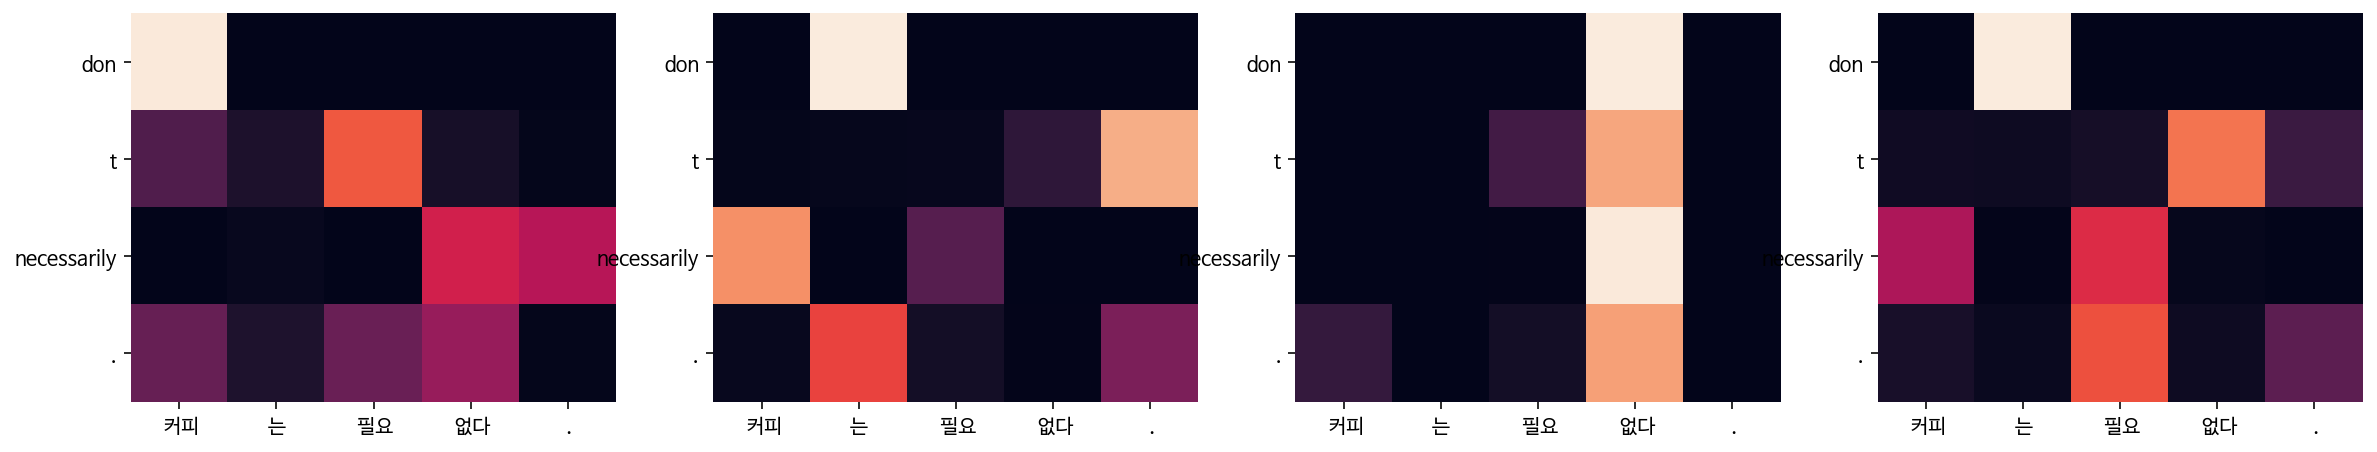

Decoder Self Layer 2


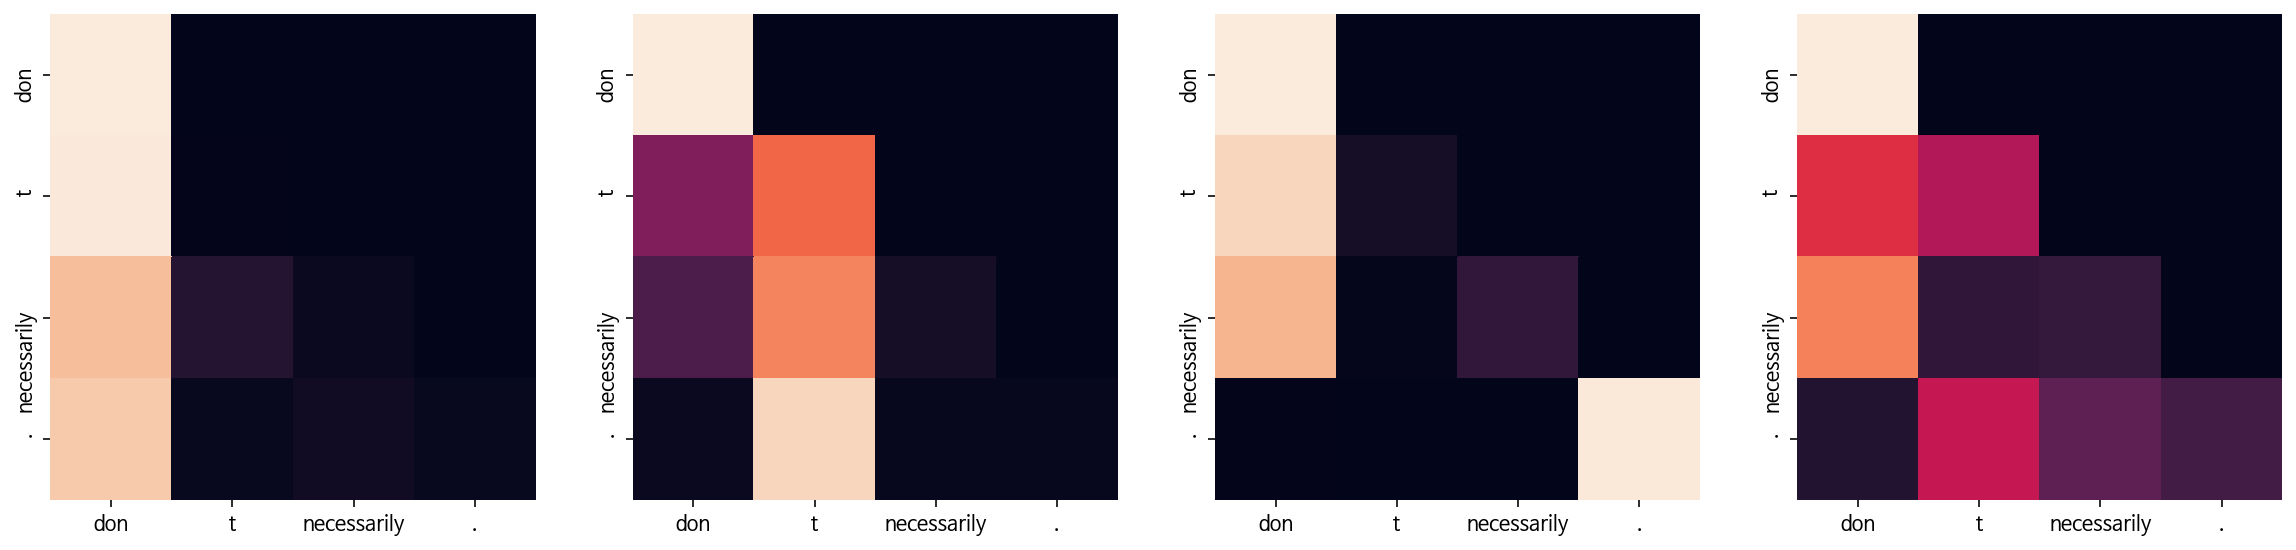

Decoder Src Layer 2


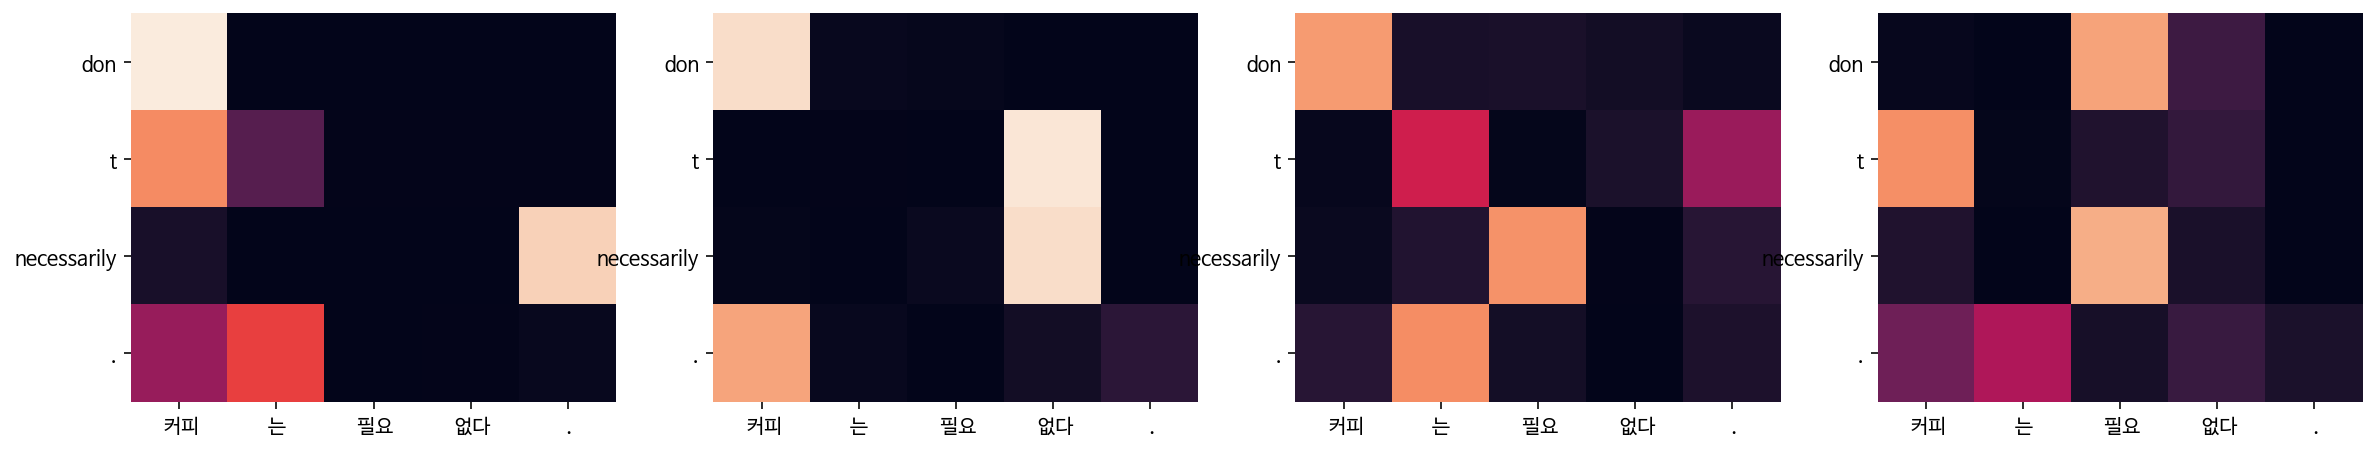

In [39]:
sentence = '커피는 필요 없다.'
translate(sentence, transformer, ko_tokenizer, en_tokenizer,True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , and 10 victims were all killed .
Encoder Layer 1


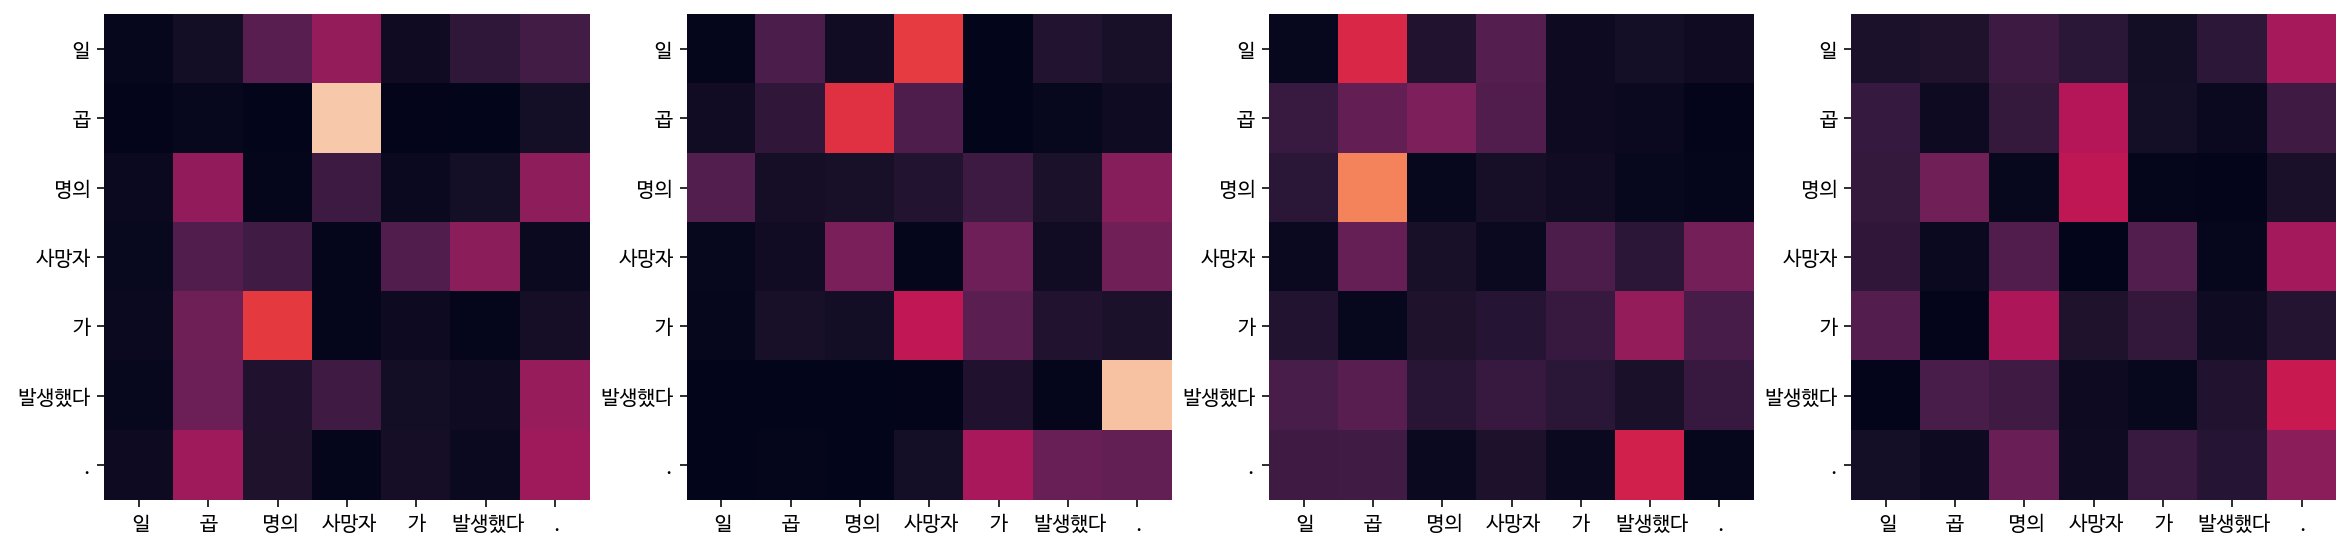

Encoder Layer 2


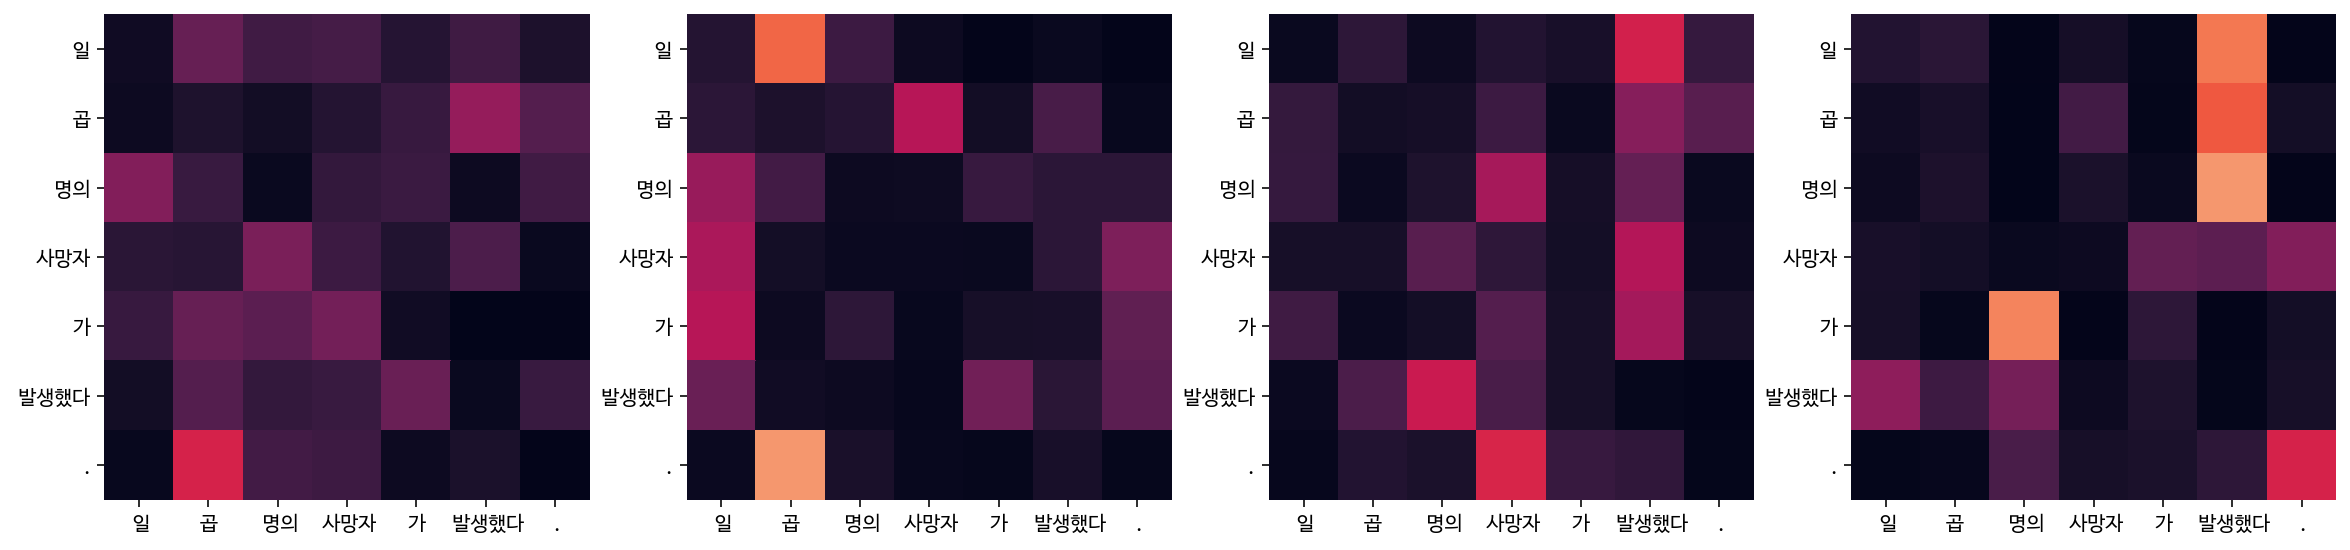

Decoder Self Layer 1


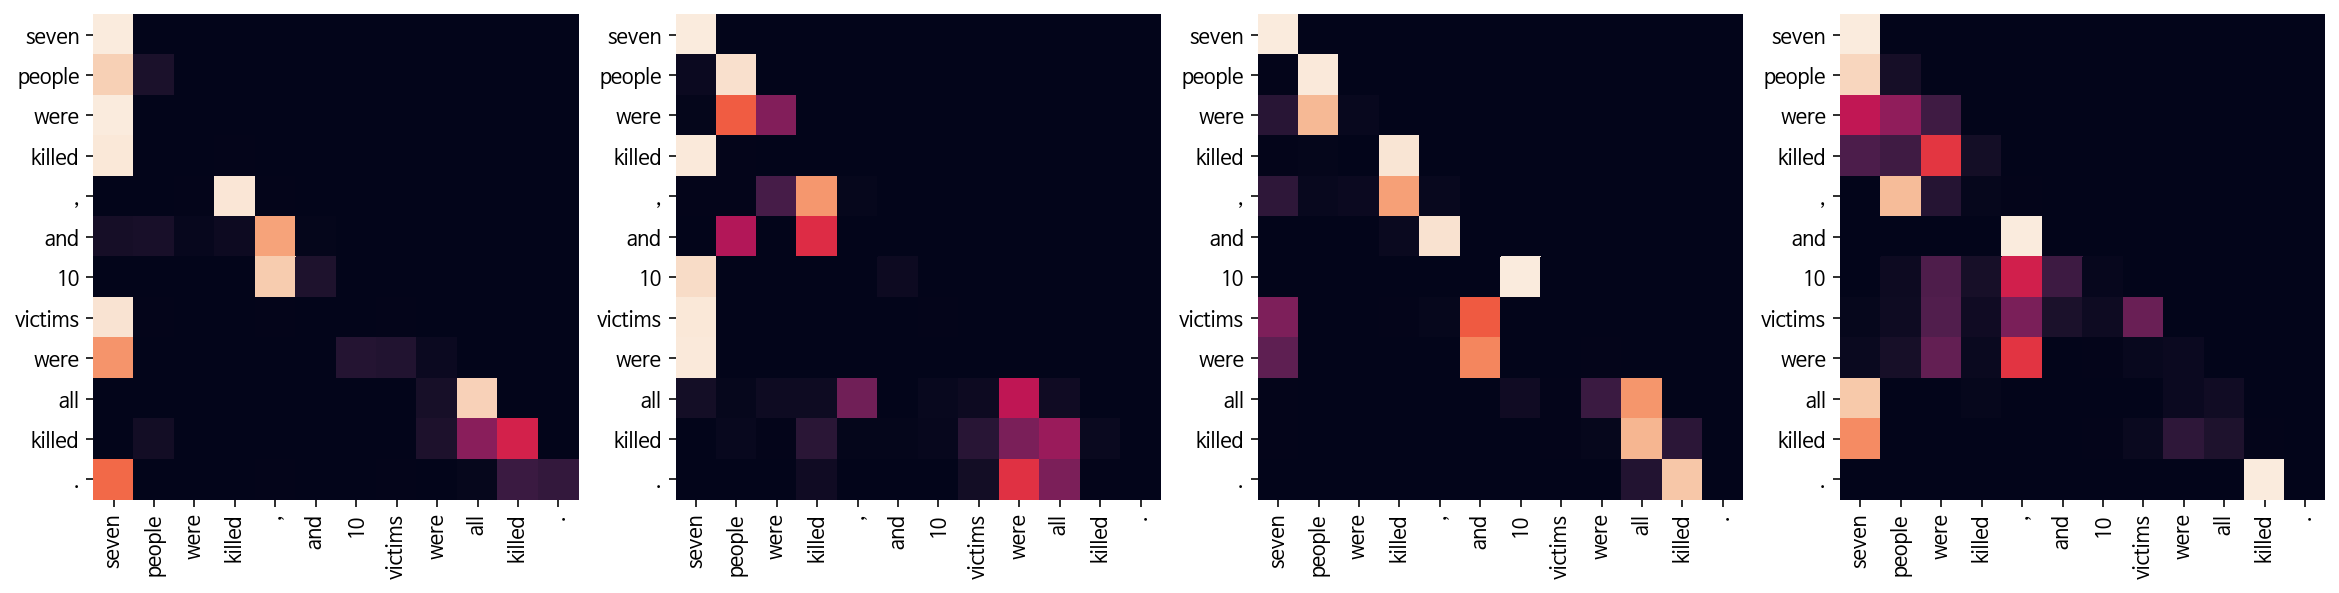

Decoder Src Layer 1


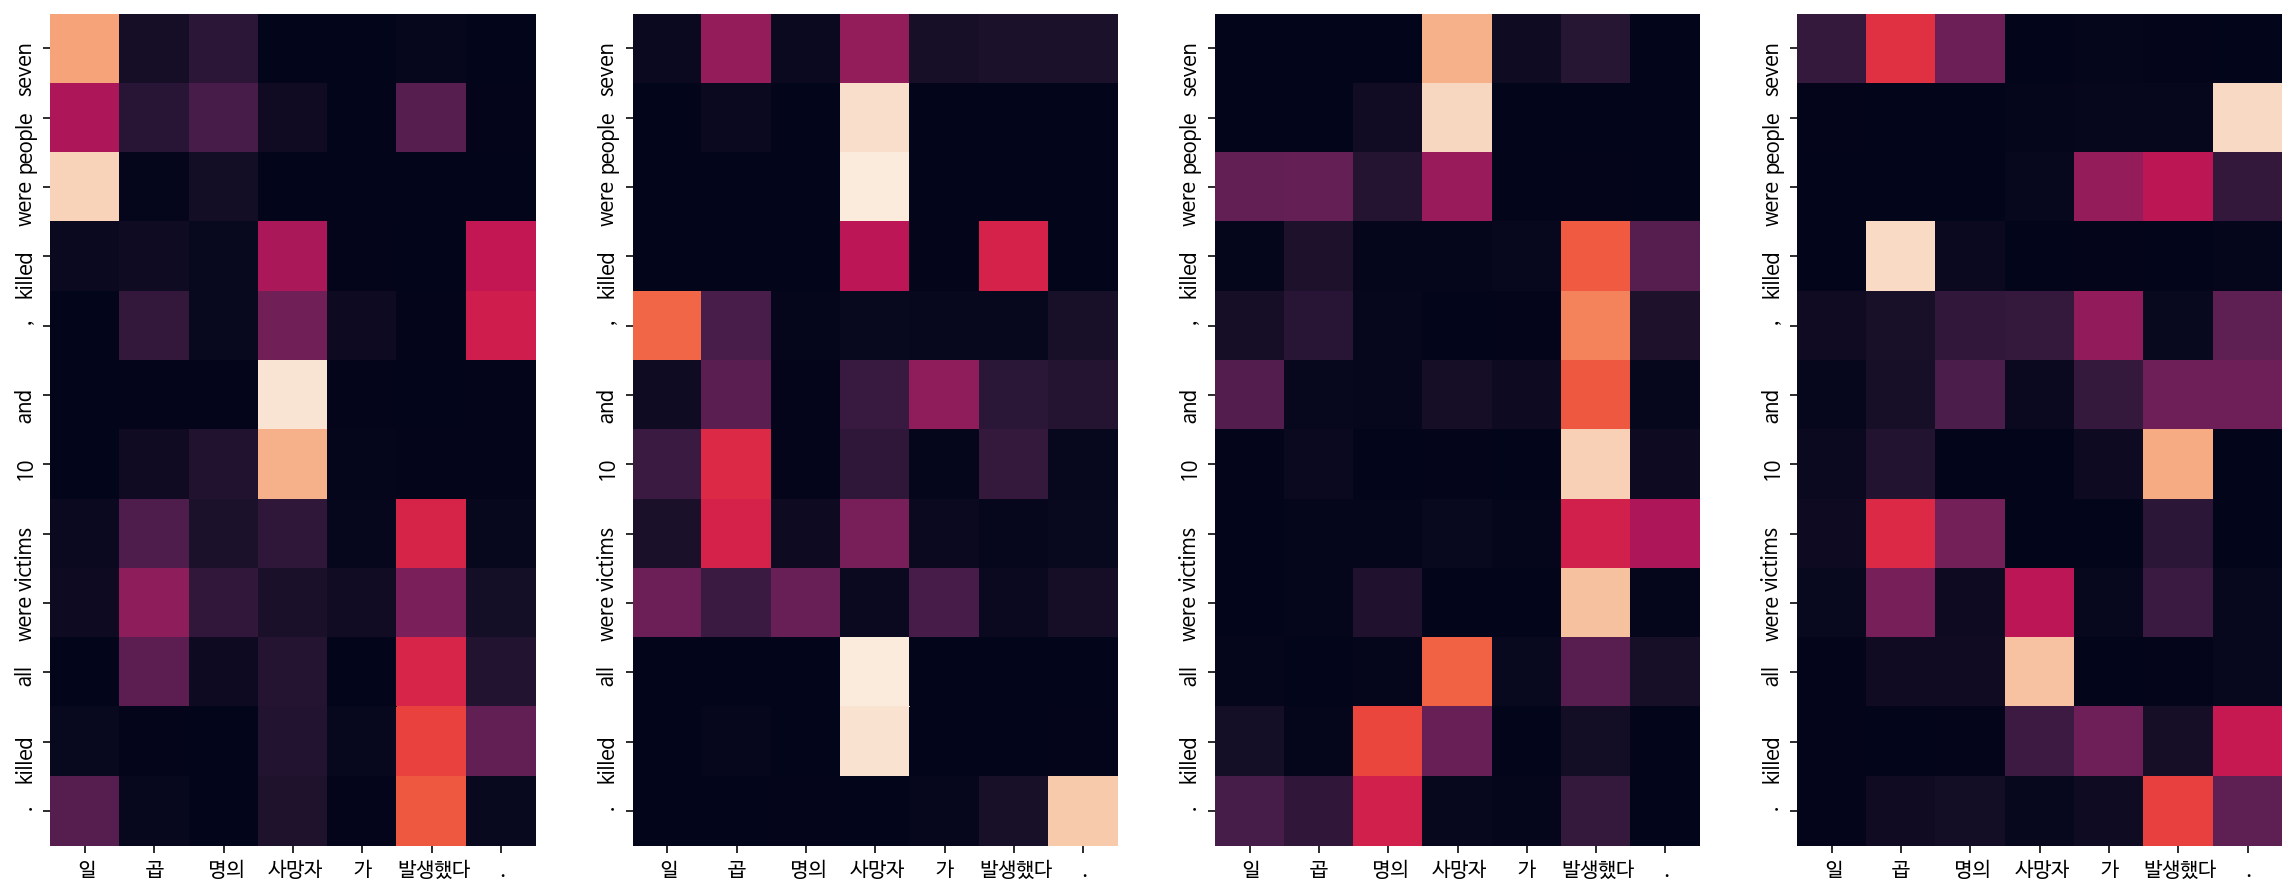

Decoder Self Layer 2


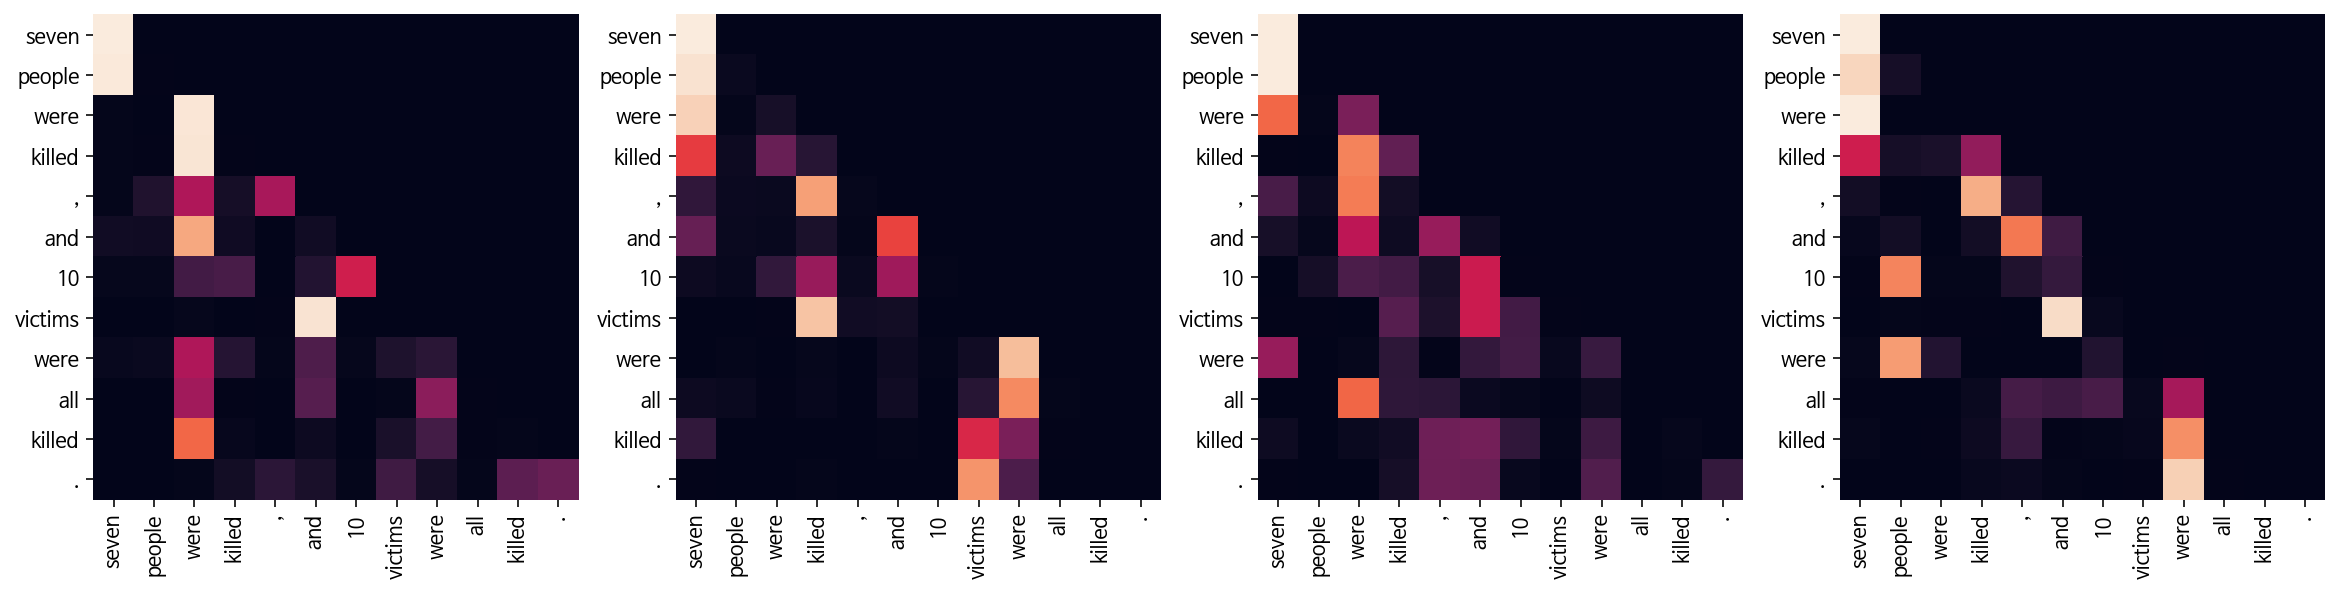

Decoder Src Layer 2


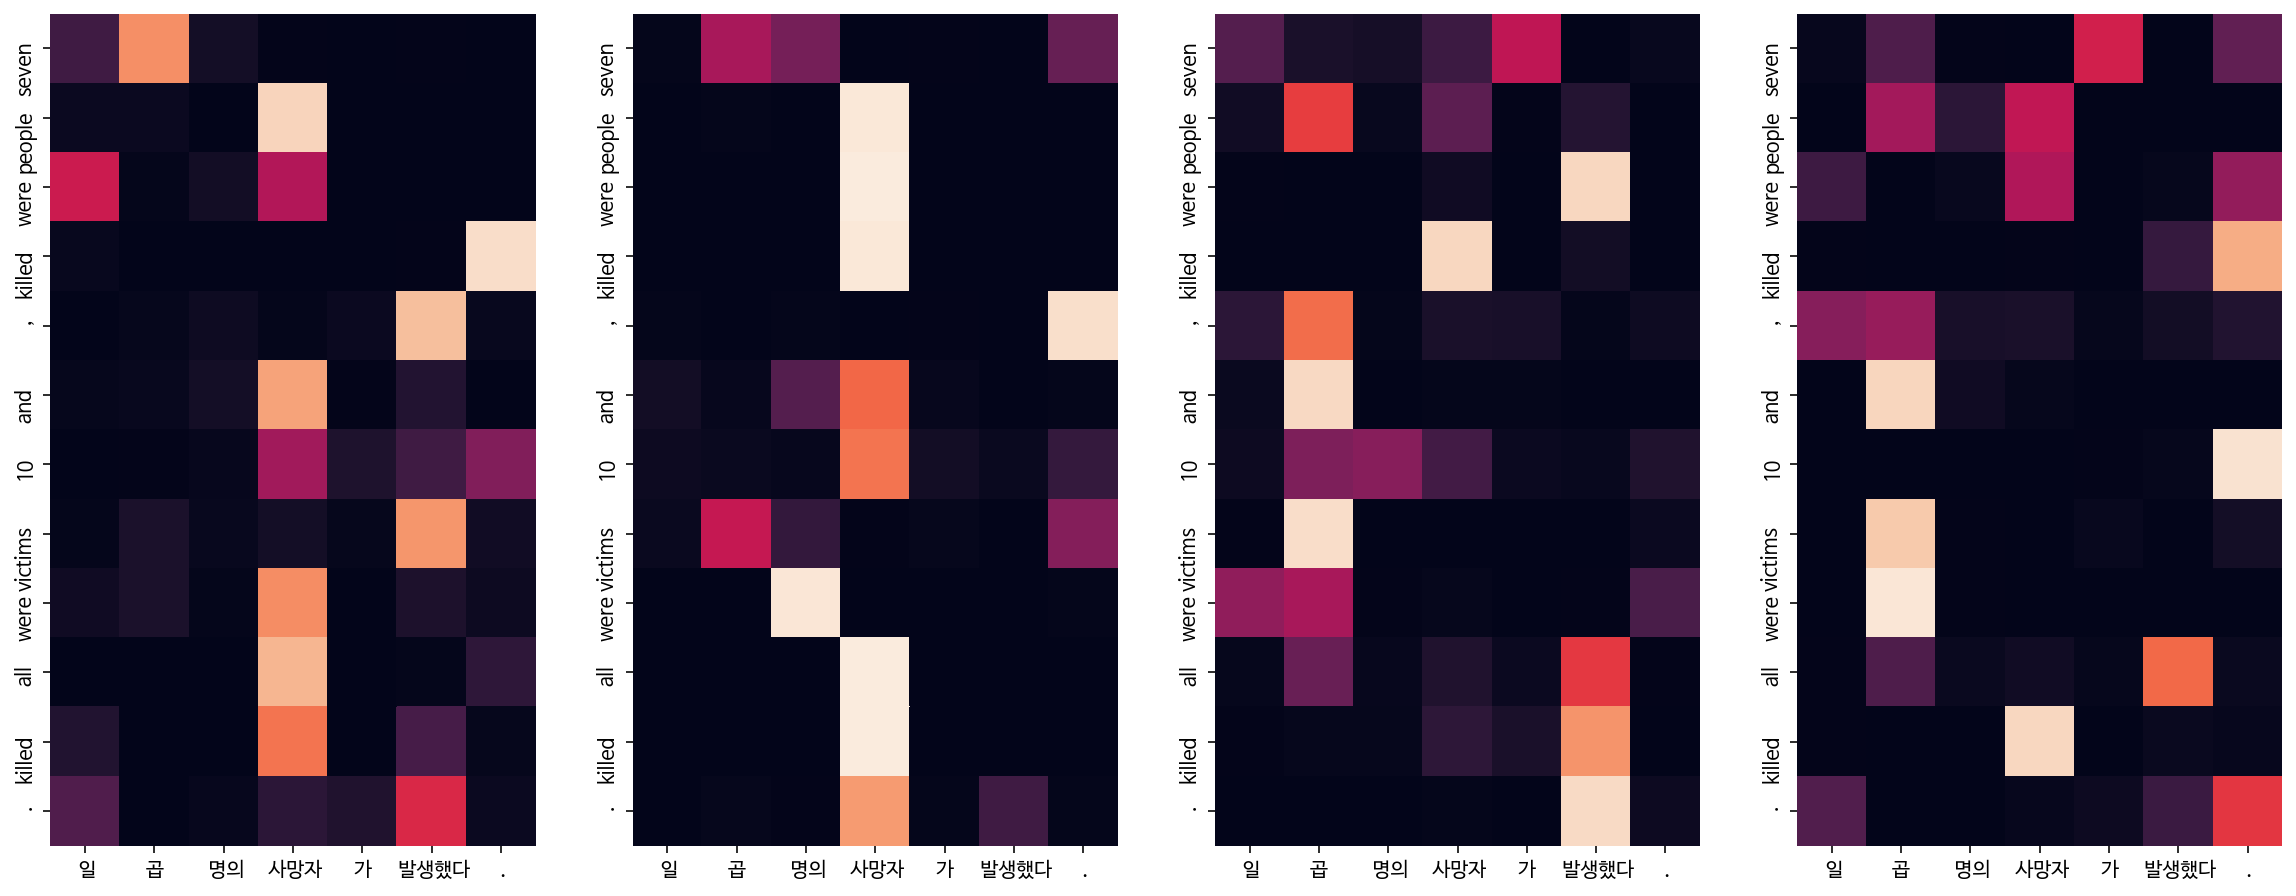

In [40]:
sentence = '일곱 명의 사망자가 발생했다.'
translate(sentence, transformer, ko_tokenizer, en_tokenizer,True)

# 확인

* 설정값
 * n_layers = 2,
 * d_model = 512,
 * n_heads = 8,
 * d_ff = 2048,
 * src_vocab_size=10000,
 * tgt_vocab_size=10000,
 * pos_len=50,
 * dropout = 0.3
 * BATCH_SIZE = 32
 * EPOCHS = 10
 
 
다음과 같이 setting 했을 때 일부 번역은 되지만 단어가 빠지거나 부자연스럽거나 이상한 단어가 들어오기도 했다.

* Input: 오바마는 대통령이다.
* Predicted translation: obama will president the president .
* Input: 시민들은 도시 속에 산다.
* Predicted translation: the city s pets .
* Input: 커피는 필요 없다.
* Predicted translation: don t necessarily .
* Input: 일곱 명의 사망자가 발생했다.
* Predicted translation: seven people were killed , and 10 victims were all killed .

전체적인 학습속도는 빠르다고 느꼈으며 n_layer, vocab_size, batch_size, epochs을 전체적으로 값을 다 올려본다면 더 좋은 성능을 기대할 수 있을 것이라 예상된다.

# 참고
* [딥러닝을 위한 자연어처리 위키독스](https://wikidocs.net/86657)
* [TensorFlow 공식홈페이지 : 언어 이해를 위한 Transfomer 모델](https://www.tensorflow.org/text/tutorials/transformer)